In [24]:
import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
NeighborListFormat = partition.NeighborListFormat

from functools import partial
import time
from typing import List, Dict, Tuple, Callable, Optional

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = jnp.triu(jnp.where(dr<dr_cutoff, 1, 0)) - jnp.eye(R.shape[0],dtype=jnp.int32)
  index_list=jnp.dstack(jnp.meshgrid(jnp.arange(N), jnp.arange(N), indexing='ij'))

  i_s = jnp.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = jnp.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = jnp.transpose(jnp.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=jnp.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=jnp.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

In [25]:
from uf3.forcefield.calculator import *
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {("W", "W"): 1.5,
             ("W", "W", "W"): [1.5, 1.5, 1.5],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 25,
                  ("W", "W", "W"): [5, 5, 10],
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_uf23.json")

calc = UFCalculator(model)

ndspline2 = calc.pair_potentials[('W','W')]
ndspline3 = calc.trio_potentials[('W','W','W')]

In [26]:
print(jnp.ones(3).device_buffer.device()) 

TFRT_CPU_0


In [27]:
coefficients2 = jnp.asarray(ndspline2.coefficients)
coefficients2 = coefficients2[:,0]

knots2 = ndspline2.knots
knots2 = knots2[0]

print(coefficients2.shape)

print(knots2.shape)

(28,)
(32,)


In [28]:
coefficients3 = jnp.asarray(ndspline3.coefficients)
coefficients3 = coefficients3[:,:,:,0]

knots3 = ndspline3.knots
knots3 = [jnp.asarray(i) for i in knots3]

print(coefficients3.shape)

print(knots3)

(8, 8, 13)
[DeviceArray([1.5, 1.5, 1.5, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.5, 3.5, 3.5],            dtype=float64), DeviceArray([1.5, 1.5, 1.5, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.5, 3.5, 3.5],            dtype=float64), DeviceArray([1.5 , 1.5 , 1.5 , 1.5 , 2.05, 2.6 , 3.15, 3.7 , 4.25, 4.8 ,
             5.35, 5.9 , 6.45, 7.  , 7.  , 7.  , 7.  ], dtype=float64)]


## Building neighbor list and data

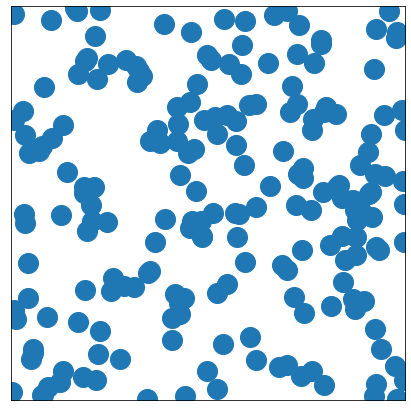

In [29]:
N = 200
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [30]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [31]:
species = onp.concatenate([onp.zeros(N//2), onp.ones(N-(N//2))])
rng = onp.random.default_rng()
rng.shuffle(species)
species = jnp.asarray(species, dtype=jnp.int16)
# print(species)
jnp.max(species)

DeviceArray(1, dtype=int16)

## Potential

In [45]:
from jax_md.energy import stillinger_weber_neighbor_list

In [49]:
nfsw, efsw = stillinger_weber_neighbor_list(displacement, box_size, cutoff=5.5)
nbrssw = nfsw.allocate(R)
efsw = jit(efsw)

In [50]:
efsw(R, nbrssw)

DeviceArray(430400.56033274, dtype=float64)

In [32]:
from uf3.jax.potentialsOLD import uf3_pair, uf3_neighbor, uf2_neighbor

nf3, ef3 = uf3_neighbor(displacement,box_size ,knots=[knots2, knots3])
nbrs3 = nf3.allocate(R)

ef3 = jit(ef3)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [33]:
print(ef3(R, neighbor=nbrs3, coefficients=[coefficients2, coefficients3]))

11674.077401136561


In [34]:
coeff_dict = {}
coeff_dict[(0,0)] = coefficients2
coeff_dict[(0,1)] = coefficients2
coeff_dict[(1,1)] = coefficients2

knot_dict = {}
knot_dict[(0,0)] = knots2
knot_dict[(0,1)] = knots2
knot_dict[(1,1)] = knots2

c3 = {}
c3[(0,0,0)] = coefficients3
c3[(0,0,1)] = coefficients3
c3[(0,1,1)] = coefficients3
c3[(1,0,0)] = coefficients3
c3[(1,0,1)] = coefficients3
c3[(1,1,1)] = coefficients3

k3 = {}
k3[(0,0,0)] = knots3
k3[(0,0,1)] = knots3
k3[(0,1,1)] = knots3
k3[(1,0,0)] = knots3
k3[(1,0,1)] = knots3
k3[(1,1,1)] = knots3

In [35]:
nf3s, ef3s = uf3_neighbor(displacement, box_size, species=species, knots=[knot_dict, k3])
nbrs3s = nf3s.allocate(R)
ef3s = jit(ef3s)

In [36]:
print(ef3s(R, neighbor=nbrs3s, coefficients=[coeff_dict, c3]))

11674.077401136561


In [37]:
nf2s, ef2s = uf2_neighbor(displacement, box_size, species=species, knots=knot_dict)
nbrs2s = nf2s.allocate(R)
ef2s = jit(ef2s)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [38]:
print(ef2s(R, neighbor=nbrs2s, coefficients=coeff_dict))

2265.697114062089


In [39]:
nf2, ef2 = uf2_neighbor(displacement, box_size, knots=knots2)
nbrs2 = nf2.allocate(R)
ef2 = jit(ef2)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [40]:
print(ef2(R, neighbor=nbrs2, coefficients=coefficients2))

2265.697114062089


In [51]:
%%timeit
efsw(R, nbrssw)

55.5 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit
ef2(R, neighbor=nbrs2, coefficients=coefficients2).block_until_ready()

6.35 ms ± 53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%%timeit
ef2s(R, neighbor=nbrs2s, coefficients=coeff_dict).block_until_ready()

9.86 ms ± 84.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%%timeit
ef3(R, neighbor=nbrs3, coefficients=[coefficients2, coefficients3]).block_until_ready()

2.02 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
ef3s(R, neighbor=nbrs3s, coefficients=[coeff_dict, c3]).block_until_ready()

4.65 s ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
